In [24]:
import gym
import random
import numpy as np
import tensorflow as tf
from collections import deque
from tensorflow.python.framework import ops
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
print("Gym:", gym.__version__)
print("Tensorflow:", tf.__version__)

Gym: 0.21.0
Tensorflow: 2.6.0


In [25]:
env_name = "CartPole-v0"
env = gym.make(env_name)
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

Observation space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Action space: Discrete(2)


In [26]:
class QNetwork():
    def __init__(self, state_dim, action_size, tau=0.01):
        ops.reset_default_graph()
        self.state_in = tf.placeholder(tf.float32, shape=[None, *state_dim])
        self.action_in = tf.placeholder(tf.int32, shape=[None])
        self.q_target_in = tf.placeholder(tf.float32, shape=[None])
        action_one_hot = tf.one_hot(self.action_in, depth=action_size)
        
        #we call q state local to create a seperate network branches for a local q state and target q state 
        self.q_state_local = self.build_model(action_size, "local")
        self.q_state_target = self.build_model(action_size, "target")
        
        #update the q state action variabl for the loss to use the local network q state vector
        self.q_state_action = tf.reduce_sum(tf.multiply(self.q_state_local, action_one_hot), axis=1)
        self.loss = tf.reduce_mean(tf.square(self.q_state_action - self.q_target_in))
        self.optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(self.loss)
        
        #we can access each network separate weights and biais variables throw tf.get_collection
        #we specify a key to get the trainable variables and the scope that the variable were created in
        self.local_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="local")
        self.target_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="target")
        #now we define our update operation for each variables in the target network with its corresponding
        #local network variables 
        #tf dollar assign lets us create an operation to assign a new value to a variable when that operation
        #is run in the session
        #set a new value as the old value plus the difference from the old value to the local values scaled by the update
        #break tab and this list of operations into a single operations using tf group and the run that in a list alongside 
        #our optimized operation each time we train the model 
        self.updater = tf.group([tf.assign(t, t + tau*(l-t)) for t,l in zip(self.target_vars, self.local_vars)])
        
    def build_model(self, action_size, scope):
        with tf.variable_scope(scope):
            hidden1 = tf.layers.dense(self.state_in, 100, activation=tf.nn.relu)
            q_state = tf.layers.dense(hidden1, action_size, activation=None)
            return q_state
        
    def update_model(self, session, state, action, q_target):
        feed = {self.state_in: state, self.action_in: action, self.q_target_in: q_target}
        session.run([self.optimizer, self.updater], feed_dict=feed)
     
    #we can just add a parameter use target
    def get_q_state(self, session, state, use_target=False):
         #set our output q state layer as the targets output if use target is true 
         #otherwise just use the original local network
        q_state_op = self.q_state_target if use_target else self.q_state_local
        q_state = session.run(q_state_op, feed_dict={self.state_in: state})
        return q_state

In [27]:
class ReplayBuffer():
    def __init__(self, maxlen):
        self.buffer = deque(maxlen=maxlen)
        
    def add(self, experience):
        self.buffer.append(experience)
        
    def sample(self, batch_size):
        sample_size = min(len(self.buffer), batch_size)
        samples = random.choices(self.buffer, k=sample_size)
        return map(list, zip(*samples))

In [28]:
#the main idea of introducing double DQN is to avoid selecting the max q value too early which we achieve by having
#one network select the action for the next state and the other network to provide q value for that action
#this way both networks have to agree on the selected action leading to the maximum q value but since we already have 
#local and a target network from the fixed q target solution we can apply these to implement double dqn as well
#so we can use the local network for selecting actions since it's already used to select actions to take in the 
#current state of the environment and then we can use the target for retrieving the q values since its values are 
#kept steadyas fixed q targets 
class DoubleDQNAgent():
    def __init__(self, env):
        self.state_dim = env.observation_space.shape
        self.action_size = env.action_space.n
        self.q_network = QNetwork(self.state_dim, self.action_size)
        self.replay_buffer = ReplayBuffer(maxlen=10000)
        self.gamma = 0.97
        self.eps = 1.0
        
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        
    def get_action(self, state):
        q_state = self.q_network.get_q_state(self.sess, [state])
        action_greedy = np.argmax(q_state)
        action_random = np.random.randint(self.action_size)
        action = action_random if random.random() < self.eps else action_greedy
        return action
    
    def train(self, state, action, next_state, reward, done, use_DDQN=True):
        self.replay_buffer.add((state, action, next_state, reward, done))
        states, actions, next_states, rewards, dones = self.replay_buffer.sample(50)
        #adjust our agents q target calculation to use the target network for getting the q values 
        #for the next state 
        #get our next actions as the argmax of the q values of the next state from the localnetwork where use 
        #target is false and this argmax is over the columns axis 
        next_actions = np.argmax(self.q_network.get_q_state(self.sess, next_states, use_target=False), axis=1)
        #by setting use target to use ddqn we can we can turn our double dqn feature on or off 
        q_next_states = self.q_network.get_q_state(self.sess, next_states, use_target=use_DDQN)
        q_next_states[dones] = np.zeros([self.action_size])
        #get the list of individual q values for each next action in the corresponding next state by indexing each
        #next state q value by its corresponding next action and this will replace the max of the q values in the 
        #q target calculation
        q_next_states_next_actions = q_next_states[np.arange(next_actions.shape[0]), next_actions]
        
        q_targets = rewards + self.gamma * q_next_states_next_actions
        self.q_network.update_model(self.sess, states, actions, q_targets)
        
        if done: self.eps = max(0.1, 0.99*self.eps)
    
    def __del__(self):
        self.sess.close()

In [30]:
#we define a variable for number of runs being 10 for this experiment
num_runs = 10
run_rewards = []

#we create a loop for each run printing the current run number and initializing a list for the total rewards from 
#each episode now since each new 
for n in range(num_runs):
    print("Run {}".format(n))
    ep_rewards = []
    #since each new agent instance creates a tensorflow session we need to make sure that sesion is 
    #closed before creating a new agent so we will first assign the agent to none which will delete the old agent 
    #and then we can create the new agent instance 
    agent = None
    agent = DoubleDQNAgent(env)
    num_episodes = 200

    for ep in range(num_episodes):
        state = env.reset()
        total_reward = 0
        done = False
        while not done:
            action = agent.get_action(state)
            next_state, reward, done, info = env.step(action)
            #use ddqn for each even number run when n mod 2 equal to 0
            agent.train(state, action, next_state, reward, done, use_DDQN=(n%2==0))
            env.render()
            total_reward += reward
            state = next_state
        #after each episode we save the total rewards to the list 
        ep_rewards.append(total_reward)
        #print("Episode: {}, total_reward: {:.2f}".format(ep, total_reward))
    #after the episode run we add that list of total rewards to a list of rewards for each run 
    run_rewards.append(ep_rewards)

Run 0
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9


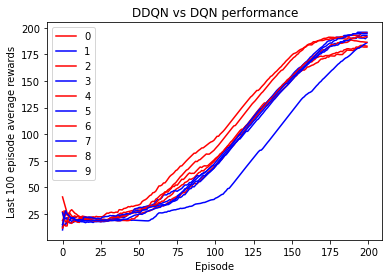

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline


for n, ep_rewards in enumerate(run_rewards):
    #save the x axis as the episode numbers 
    x = range(len(ep_rewards))
    #we want to plotthe average rewards for each episode of the last 100 episode 
    #we create a list of cumulative total rewards at each episode which we can get from numpy fcts 
    cumsum = np.cumsum(ep_rewards)
    #for the first 100 episodes we just take the average reward but then after that wesubstract the accumulation from 
    #100 episodes back to get the sum of the rewards of the last 100episodes which we just average out
    avgs = [cumsum[ep]/(ep+1) if ep<100 else (cumsum[ep]-cumsum[ep-100])/100 for ep in x]
    #we use the color red to distinguish the runs which use ddqn and blue for dqn 
    col = "r" if (n%2==0) else "b"
    plt.plot(x, avgs, color=col, label=n)
    
plt.title("DDQN vs DQN performance")
plt.xlabel("Episode")
plt.ylabel("Last 100 episode average rewards")
plt.legend()
#ddqn allows for a faster increase in the total reward over fewer episodes 

In [32]:
env.close()